In [45]:
import requests
import json
import pandas as pd
from time import sleep
import geopandas as gpd
from shapely.geometry import Point
import re

In [ ]:
# Instantiate a session
session = requests.Session()
# Get query states to get state IDs
response = session.get(url='https://api.countyhealthrankings.org/states/2024')

# Convert response to a json object
response_json = json.loads(response.text)

In [23]:
# Create a list of state IDs
state_ids = [str(id).zfill(2) for id in response_json.keys()]

In [27]:
# Get alcoholism stats by county
data = []
for state_id in state_ids:
    print(f'Requesting state {state_id}...')
    # Format is measure/{year}/{state_id}/{countyid}/{measureid}
        # measureid 49 is 'Excessive Drinking'
        # You'd think I would have to do a separate query for every county, but actually just setting countyid to 1 will still show me the data for all counties in the state
        # Therefore, I only have to query for each state
    response = session.get(url=f'https://api.countyhealthrankings.org/measure/2024/{state_id}/1/49') 
    response_json = json.loads(response.text)
    print(f'{len(response_json["counties"])} results')
    for countyid in response_json['counties'].keys():
        county_data = response_json['counties'][countyid]
        # County data (county id, county name, state) and measure values (county id, alcohol) are found in different parts of the json, so this joins them in one dictionary
        try:
            county_data.update(response_json['measureValues'][countyid])    # Some county IDs were not found in the measureValues, so this will skip them (rare)
        except:
            county_data.update({'data':'', 'highlight': 0})
        finally:
            data.append(county_data)
    # sleep(5) Optional, but it is sometimes good idea to give the endpoint a rest between queries. Some servers automatically block rapid requests to prevent DDoS 

df = pd.DataFrame(data)
df

Requesting state 01...
67 results
Requesting state 02...
35 results
Requesting state 04...
15 results
Requesting state 05...
75 results
Requesting state 06...
58 results
Requesting state 08...
64 results
Requesting state 09...
8 results
Requesting state 10...
3 results
Requesting state 11...
1 results
Requesting state 12...
67 results
Requesting state 13...
159 results
Requesting state 15...
5 results
Requesting state 16...
44 results
Requesting state 17...
102 results
Requesting state 18...
92 results
Requesting state 19...
99 results
Requesting state 20...
105 results
Requesting state 21...
120 results
Requesting state 22...
64 results
Requesting state 23...
16 results
Requesting state 24...
24 results
Requesting state 25...
14 results
Requesting state 26...
83 results
Requesting state 27...
87 results
Requesting state 28...
82 results
Requesting state 29...
115 results
Requesting state 30...
56 results
Requesting state 31...
93 results
Requesting state 32...
17 results
Requesting st

,id,name,path,state_fips,county_fips,suffix,abbreviation,state_abbr,applicable,applicableYears,data,highlight
0,001,Autauga (AU),autauga,01,001,County,AU,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",15%,0
1,003,Baldwin (BA),baldwin,01,003,County,BA,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",16%,0
2,005,Barbour (BR),barbour,01,005,County,BR,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",12%,1
3,007,Bibb (BI),bibb,01,007,County,BI,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",15%,1
4,009,Blount (BL),blount,01,009,County,BL,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",15%,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3145,037,Sweetwater (SW),sweetwater,56,037,County,SW,WY,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",19%,0
3146,039,Teton (TE),teton,56,039,County,TE,WY,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",23%,2
3147,041,Uinta (UI),uinta,56,041,County,UI,WY,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",17%,0
3148,043,Washakie (WA),washakie,56,043,County,WA,WY,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",16%,0


In [29]:
# Save to CSV
df.to_csv('excessive_alcohol.csv', index=False)

In [105]:
# Load the CSV rather than requery everything
df = pd.read_csv('excessive_alcohol.csv')
df.head()

,id,name,path,state_fips,county_fips,suffix,abbreviation,state_abbr,applicable,applicableYears,data,highlight
0,1,Autauga (AU),autauga,1,1,County,AU,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",15%,0
1,3,Baldwin (BA),baldwin,1,3,County,BA,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",16%,0
2,5,Barbour (BR),barbour,1,5,County,BR,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",12%,1
3,7,Bibb (BI),bibb,1,7,County,BI,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",15%,1
4,9,Blount (BL),blount,1,9,County,BL,AL,1,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",15%,0


In [106]:
# Keep only important columns
df = df[['path', 'state_abbr', 'data']]

# Clean column names
df = df.rename(columns={'path':'countyName', 'state_abbr':'state', 'data':'excessiveAlcohol'})

# Put county names in title case
df['countyName'] = df['countyName'].str.title()

# Set aside the counties that had no alcohol data, in case it has value
no_data = df[df['excessiveAlcohol'].isnull()]

# Remove null values
df = df[~df['excessiveAlcohol'].isnull()]

# Convert the excessiveAlcohol values from strings (18%) to floats (0.18)
df['excessiveAlcohol'] = df['excessiveAlcohol'].str.replace('%', '').astype(float) / 100
df.head()

,countyName,state,excessiveAlcohol
0,Autauga,AL,0.15
1,Baldwin,AL,0.16
2,Barbour,AL,0.12
3,Bibb,AL,0.15
4,Blount,AL,0.15


In [22]:
# Check that no_data has some rows
no_data


,countyName,state,excessiveAlcohol
91,Prince-Of-Wales-Outer-Ketchikan,AK,NaN
94,Skagway-Hoonah-Angoon,AK,NaN
96,Valdez-Cordova,AK,NaN
97,Wade-Hampton,AK,NaN
99,Wrangell-Petersburg,AK,NaN
2424,Shannon,SD,NaN
2923,Bedford-City,VA,NaN


In [46]:
# Load UFO sightings dataset
ufo = pd.read_csv('UFO_scrubbed.csv', usecols=['datetime', 'city', 'state', 'shape', 'duration (seconds)', 'latitude', 'longitude '], low_memory=False)

# Rename columns
ufo = ufo.rename(columns={'duration (seconds)':'duration_s',
                    'latitude': 'lat',
                    'longitude ':'lon'})

# The latitude column is read in as an object dtype because at least one value has a random 'q' in the numbers. This function is designed to strip unwanted characters out.
def clean_value(value):
    # Use regular expression to keep only digits and decimal points
    cleaned_value = re.sub(r'[^\d.]', '', value)
    return cleaned_value

ufo['lat'] = ufo['lat'].apply(clean_value)

# Converting the column dtype to float
ufo['lat'] = ufo['lat'].astype(float)

In [47]:
# Load the shapefile
shapefile_path = 'cb_2018_us_county_5m/cb_2018_us_county_5m.shp'
counties = gpd.read_file(shapefile_path)

# Create a spatial index
sindex = counties.sindex

# Function to find county based on latitude and longitude using spatial index
def find_county(row, counties, sindex):
    point = Point(row['lon'], row['lat'])
    possible_matches_index = list(sindex.intersection(point.bounds))
    possible_matches = counties.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['NAME']
    return None

# Assuming 'ufo' is your DataFrame with 'lat' and 'lon' columns
ufo['county'] = ufo.apply(find_county, counties=counties, sindex=sindex, axis=1)
ufo


,datetime,city,state,shape,duration_s,lat,lon,county
0,10/10/1949 20:30,san marcos,tx,cylinder,2700,29.883056,-97.941111,Hays
1,10/10/1949 21:00,lackland afb,tx,light,7200,29.384210,-98.581082,Bexar
2,10/10/1955 17:00,chester (uk/england),NaN,circle,20,53.200000,-2.916667,None
3,10/10/1956 21:00,edna,tx,circle,20,28.978333,-96.645833,Jackson
4,10/10/1960 20:00,kaneohe,hi,light,900,21.418056,-157.803611,Honolulu
...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,light,600,36.165833,-86.784444,Davidson
80328,9/9/2013 22:00,boise,id,circle,1200,43.613611,-116.202500,Ada
80329,9/9/2013 22:00,napa,ca,other,1200,38.297222,-122.284444,Napa
80330,9/9/2013 22:20,vienna,va,circle,5,38.901111,-77.265556,Fairfax


In [80]:
# Save to CSV
ufo.to_csv('ufo_with_county.csv', index=False)

In [85]:
ufo_no_null = ufo.dropna(subset=['county', 'state'])
ufo_no_null = ufo_no_null.rename(columns={'county':'countyName'})
ufo_no_null['state'] = ufo_no_null['state'].str.upper()

In [86]:
sightings_by_county = ufo_no_null.groupby(['countyName', 'state']).size().reset_index(name='count')
sightings_by_county.head()

,countyName,state,count
0,Abbeville,SC,3
1,Acadia,LA,9
2,Accomack,VA,10
3,Ada,ID,147
4,Adair,IA,3


In [83]:
df

,countyName,state,excessiveAlcohol
0,Autauga,AL,0.15
1,Baldwin,AL,0.16
2,Barbour,AL,0.12
3,Bibb,AL,0.15
4,Blount,AL,0.15
...,...,...,...
3145,Sweetwater,WY,0.19
3146,Teton,WY,0.23
3147,Uinta,WY,0.17
3148,Washakie,WY,0.16


In [87]:
merged = pd.merge(sightings_by_county, df, how='outer', on=['state', 'countyName'])
merged

,countyName,state,count,excessiveAlcohol
0,Kent,AB,1.0,NaN
1,Powell,AB,1.0,NaN
2,Aleutians East,AK,1.0,NaN
3,Aleutians West,AK,3.0,NaN
4,Aleutians-East,AK,NaN,0.16
...,...,...,...,...
3566,Sweetwater,WY,21.0,0.19
3567,Teton,WY,14.0,0.23
3568,Uinta,WY,9.0,0.17
3569,Washakie,WY,2.0,0.16


In [107]:
import difflib

df['countyName'] = df['countyName'].apply(lambda x: difflib.get_close_matches(x, sightings_by_county['countyName']))
df


,countyName,state,excessiveAlcohol
0,"[Autauga, Watauga, Outagamie]",AL,0.15
1,"[Baldwin, Baldwin, Gladwin]",AL,0.16
2,"[Barbour, Barbour, Barber]",AL,0.12
3,"[Bibb, Bibb]",AL,0.15
4,"[Blount, Blount, Belmont]",AL,0.15
...,...,...,...
3145,"[Sweetwater, Stillwater, Sutter]",WY,0.19
3146,"[Teton, Teton, Teton]",WY,0.23
3147,"[Uinta, Uintah, Utah]",WY,0.17
3148,"[Washakie, Washoe, Washoe]",WY,0.16


In [108]:
df['countyName'] = df['countyName'].apply(lambda x: '' if len(x) == 0 else x[0])
df

,countyName,state,excessiveAlcohol
0,Autauga,AL,0.15
1,Baldwin,AL,0.16
2,Barbour,AL,0.12
3,Bibb,AL,0.15
4,Blount,AL,0.15
...,...,...,...
3145,Sweetwater,WY,0.19
3146,Teton,WY,0.23
3147,Uinta,WY,0.17
3148,Washakie,WY,0.16


In [110]:
merged = pd.merge(sightings_by_county, df, how='outer', on=['state', 'countyName'])

<Axes: xlabel='excessiveAlcohol', ylabel='count'>

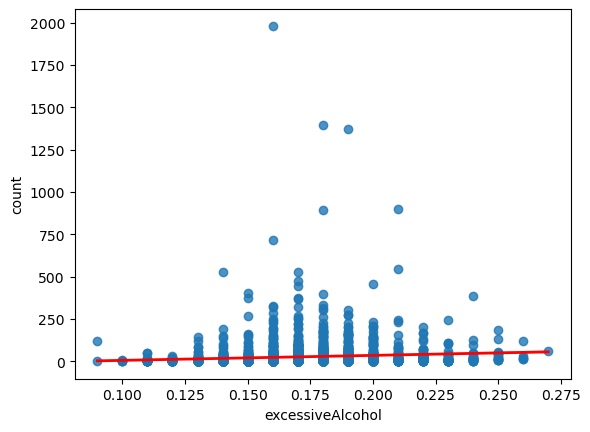

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.scatterplot(data=merged, x='excessiveAlcohol', y='count')
sns.regplot(x='excessiveAlcohol', y='count', data=merged, ci=95, line_kws={'color': 'red', 'lw': 2})

In [115]:
# To do:
# Include population data so that ufo sightings can be normalized (per capita)
# DONE: Reshape the UFO data to count sightings per county
# DONE: Merge the UFO data with the alcohol data (may be difficult, fuzzy matching might be necessary)
# DONE: Create a scatterplot showing correlation between UFO sightings an alcoholism
merged

,countyName,state,count,excessiveAlcohol
0,Kent,AB,1.0,NaN
1,Powell,AB,1.0,NaN
2,Aleutians East,AK,1.0,0.16
3,Aleutians West,AK,3.0,0.20
4,Anchorage,AK,97.0,0.20
...,...,...,...,...
3322,Sweetwater,WY,21.0,0.19
3323,Teton,WY,14.0,0.23
3324,Uinta,WY,9.0,0.17
3325,Washakie,WY,2.0,0.16


In [72]:
df['countyName'].value_counts()

countyName
Washington        31
Jefferson         26
Franklin          25
Jackson           24
Lincoln           24
                  ..
Queen-Annes        1
Prince-Georges     1
Harford            1
Garrett            1
Weston             1
Name: count, Length: 1851, dtype: int64

In [73]:
ufo_no_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70866 entries, 0 to 80331
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    70866 non-null  object 
 1   city        70866 non-null  object 
 2   state       70753 non-null  object 
 3   shape       69133 non-null  object 
 4   duration_s  70866 non-null  object 
 5   lat         70866 non-null  float64
 6   lon         70866 non-null  float64
 7   countyName  70866 non-null  object 
dtypes: float64(2), object(6)
memory usage: 4.9+ MB
